#### Andrew Taylor
#### atayl136
#### EN705.601.83 Applied Machine Learning
## Homework 13 - Image Classification Using PyTorch

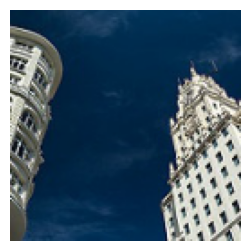

Number of color channels: 3
Training set size: (14034, 128, 128, 3)
Testing set size: (14034, 128, 128, 3)


In [3]:
# Question 1: Download and explore, then load dataset into training and test groups.
# Provided code snippet was modified, and 0.2 selected for test split.
# We define a function load_images_from_directory to load images from a specified directory.
# The shapes of the training and testing sets are printed to verify their sizes.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Constants
IMGSIZE = 128
CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
data_dir = r'C:\Users\Putna\OneDrive - Johns Hopkins\Documents\Johns Hopkins\Applied Machine Learning\HW13\archive\seg_train\seg_train'  # Update this path

# Function to load images from a directory
def load_images_from_directory(directory):
    images, labels = [], []
    for label in CNAMES:
        path = os.path.join(directory, label)
        for f in sorted([_ for _ in os.listdir(path) if _.lower().endswith('.jpg')]):
            img = cv2.imread(os.path.join(path, f))
            img = cv2.resize(img, (IMGSIZE, IMGSIZE))
            images.append(img)
            labels.append(CNAMES.index(label))
    return images, labels

# Function to display images using matplotlib
def display_images(images, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        # Convert BGR to RGB for displaying
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Load training images
X_train, y_train = load_images_from_directory(data_dir)

# Load testing images
X_test, y_test = load_images_from_directory(data_dir)

# Convert to NumPy arrays and scale
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0

# Display a few images from the training set
display_images(X_train)

# Determine and print the number of color channels
color_channels = X_train.shape[3]
print(f"Number of color channels: {color_channels}")

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


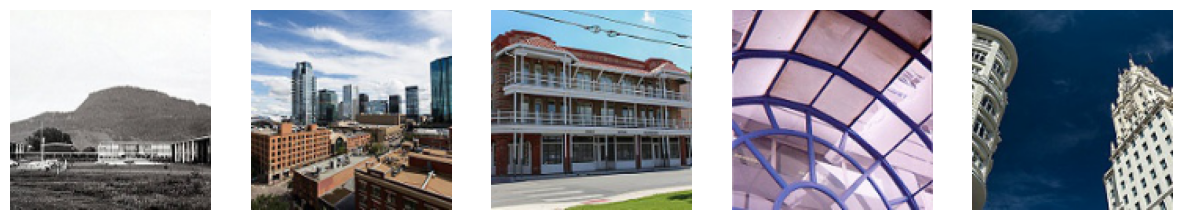

In [4]:
# Display the first 5 images

# Function to display images using matplotlib
def display_images(images, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        # Convert BGR to RGB for displaying
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Display a few images from the training set
display_images(X_train)

In [5]:
# Question 2: Convert and scale the imageset as numpy arrays

# Convert training and testing sets to NumPy arrays
X_train_np = np.array(X_train, dtype=np.float32)
X_test_np = np.array(X_test, dtype=np.float32)

# Scale the images to [0, 1]
X_train_scaled = X_train_np / 255.0
X_test_scaled = X_test_np / 255.0

# Print the shapes to verify
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")


Training set shape: (14034, 128, 128, 3)
Testing set shape: (14034, 128, 128, 3)


In [6]:
# Question 3: Training and testing an image classifier
# I chose the same 50,50,50 network at 200 epochs for comparison

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Assuming each image is 128x128x3, flatten to 49152
        self.fc1 = nn.Linear(128 * 128 * 3, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, len(CNAMES))  # Output layer: number of classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation, as we'll use CrossEntropyLoss
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 128*128*3))
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 128*128*3))
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(200):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{200}, Loss: {loss.item()}")
    
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Evaluate on training and testing sets
train_preds, train_labels = evaluate_model(model, train_loader)
test_preds, test_labels = evaluate_model(model, test_loader)

# Calculate and print the classification report
print("Classification Report (Training):")
print(classification_report(train_labels, train_preds, target_names=CNAMES))

print("\nClassification Report (Testing):")
print(classification_report(test_labels, test_preds, target_names=CNAMES))

# Reclassification Accuracy (Training)
train_accuracy = 100 * np.mean(np.array(train_preds) == np.array(train_labels))
print(f"\nReclassification Accuracy (Training): {train_accuracy}%")

# Testing Accuracy
test_accuracy = 100 * np.mean(np.array(test_preds) == np.array(test_labels))
print(f"Testing Accuracy: {test_accuracy}%")


Epoch 1/200, Loss: 1.2507034540176392
Epoch 2/200, Loss: 1.3115915060043335
Epoch 3/200, Loss: 1.2974495887756348
Epoch 4/200, Loss: 1.1000765562057495
Epoch 5/200, Loss: 1.195924162864685
Epoch 6/200, Loss: 1.4084372520446777
Epoch 7/200, Loss: 0.899242639541626
Epoch 8/200, Loss: 1.233384609222412
Epoch 9/200, Loss: 0.8032002449035645
Epoch 10/200, Loss: 0.8403870463371277
Epoch 11/200, Loss: 1.1596386432647705
Epoch 12/200, Loss: 0.758545994758606
Epoch 13/200, Loss: 0.8616951704025269
Epoch 14/200, Loss: 0.8355291485786438
Epoch 15/200, Loss: 0.9435833692550659
Epoch 16/200, Loss: 1.296162486076355
Epoch 17/200, Loss: 0.8033748865127563
Epoch 18/200, Loss: 0.7100943326950073
Epoch 19/200, Loss: 0.9505634307861328
Epoch 20/200, Loss: 0.6649153828620911
Epoch 21/200, Loss: 0.7105293869972229
Epoch 22/200, Loss: 0.740118682384491
Epoch 23/200, Loss: 0.8170332908630371
Epoch 24/200, Loss: 1.0363590717315674
Epoch 25/200, Loss: 0.4880257844924927
Epoch 26/200, Loss: 0.7451795935630798
E

              precision    recall  f1-score   support

   buildings       0.96      1.00      0.98      2191
      forest       1.00      1.00      1.00      2271
     glacier       0.99      0.96      0.97      2404
    mountain       0.99      0.88      0.93      2512
         sea       0.88      0.98      0.93      2274
      street       1.00      0.98      0.99      2382

    accuracy                           0.97     14034
   macro avg       0.97      0.97      0.97     14034
weighted avg       0.97      0.97      0.97     14034


Reclassification Accuracy (Training): 96.55835827276614%
Testing Accuracy: 96.55835827276614%


I got these results, which I consider extremely good. The only concern I have is the reclassfication and testing accuracy are the same, which is not impossible but may indicate problems in the datasets diversity or my testing methodology. In the case I consider it a coincidence because it appears the split worked. One question I have is why are my results so much better than Dr. Guven's considering I chose the same network and the same number of epochs. Training and testing accuracy is the same indicating no overfit. These are questions I have left over.

### Question 4: Improving Results Even Further


## Improving the Neural Network Model for Image Classification

Improving our neural network model involves several strategies. These can be broadly categorized into data handling, model architecture adjustments, training process enhancements, and post-training analysis. Here's a structured approach:

### 1. Data Handling
- **Augmentation**: Implement data augmentation to increase the diversity of our training set, which can help prevent overfitting. Techniques like rotation, scaling, flipping, and color adjustments can make our model more robust.
- **Normalization**: Ensure that the data is properly normalized. We've already scaled the images to [0, 1], but consider other normalization methods like Z-score normalization if necessary.
- **Balanced Dataset**: Verify that the dataset is balanced across different classes. If there are imbalances, consider techniques like oversampling the minority class or undersampling the majority class.

### 2. Model Architecture Adjustments
- **Convolutional Neural Networks (CNNs)**: For image data, CNNs are typically more effective than fully connected networks. Consider using a CNN with layers like Conv2D, MaxPooling, etc.
- **Regularization**: Implement dropout layers to prevent overfitting. Dropout randomly sets a fraction of input units to 0 at each update during training time, which helps in preventing overfitting.
- **Varying Layer Sizes**: Experiment with different sizes for our hidden layers. Sometimes, a larger layer followed by progressively smaller layers can be effective.

### 3. Training Process Enhancements
- **Learning Rate Scheduling**: Implement learning rate scheduling or use optimizers like Adam, which adjust the learning rate during training.
- **Early Stopping**: Use early stopping to halt the training when the performance on the validation set starts to degrade.
- **Batch Normalization**: Utilize batch normalization to stabilize and accelerate the training process.
- **Loss Function**: Experiment with different loss functions if the current one is not yielding good results.

### 4. Advanced Techniques
- **Transfer Learning**: Leverage a pre-trained model (like VGG, ResNet, etc.) and fine-tune it on our dataset. This is particularly effective when we have a relatively small dataset.
- **Hyperparameter Tuning**: Utilize techniques like grid search or random search to find the optimal set of hyperparameters.

### 5. Post-Training Analysis
- **Confusion Matrix**: Analyze the confusion matrix to understand the specific areas where the model is making mistakes.
- **Class-specific Performance**: Look at the performance metrics like precision, recall, and F1-score for each class to identify if the model is struggling with specific classes.
- **Error Analysis**: Perform an error analysis to see what kind of mistakes the model is making and consider strategies to address them.

### 6. Experimentation and Iteration
- **Iterative Approach**: Machine learning is an iterative process. Make changes gradually and evaluate their impact.
- **Logging and Visualization**: Use tools like TensorBoard for logging and visualizing the training process, which can offer insights for further improvements.

By following this structured approach and iteratively experimenting with these strategies, we can improve our neural network model's performance for the image classification task, which I assume we'll save for next time, because the question only asked to outline the approach. A truly large improvement may be difficult to achieve with such a high initial performance, which is a good thing.